# Load dataset, preprocess

In [196]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
from transformers import BertTokenizer, BertModel
import torch


In [197]:
# Load dataset
df = pd.read_csv("cleaned_call_logs.csv")

In [198]:
# Preprocessing function
def clean_text(text):
    text = re.sub(r"caller:|receiver:", "", text, flags=re.IGNORECASE)  # Remove labels
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df["cleaned_dialogue"] = df["dialogue"].apply(clean_text)

# Generate Vector/Embeddings

In [199]:
# 1. CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_count = count_vectorizer.fit_transform(df["cleaned_dialogue"])

# 2. TF-IDF (current approach)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_dialogue"])

# 3. Word2Vec
# Prepare sentences for Word2Vec
sentences = [text.split() for text in df["cleaned_dialogue"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

# Create document vectors by averaging word vectors
X_w2v = np.zeros((len(sentences), 100))
for idx, sentence in enumerate(sentences):
    vectors = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    if vectors:
        X_w2v[idx] = np.mean(vectors, axis=0)

In [200]:
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd  # Assuming you're using pandas

# Generate BERT Vector/Embeddings (Recommended use GPU)

In [201]:
# 4. BERT
# Tokenize the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode text
def encode_text(text):
    try:  # Add a try-except block
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add [CLS] and [SEP]
            max_length=512,  # Pad & truncate all sentences
            padding='max_length',
            truncation=True,  # Explicitly set truncation to True
            return_attention_mask=True,
            return_tensors='pt',  # Return PyTorch tensors
        )
        return encoded['input_ids'], encoded['attention_mask']
    except Exception as e:
        print(f"Error encoding text: {text}")  # Print the problematic text
        print(f"Error: {e}")
        return None, None  # Return None values to signal an error

# Encode the cleaned dialogues
input_ids = []
attention_masks = []
problematic_indices = []  # Keep track of indices with errors

for i, dialogue in enumerate(tqdm(df['cleaned_dialogue'], desc="Tokenizing and Encoding")):
    ids, mask = encode_text(dialogue)
    if ids is not None and mask is not None:  # Check for None values (errors)
        input_ids.append(ids)
        attention_masks.append(mask)
    else:
        problematic_indices.append(i)
        print(f"Skipping dialogue at index {i}")

# Remove rows with errors from the DataFrame
if problematic_indices:
    df = df.drop(problematic_indices).reset_index(drop=True)  # Corrected DataFrame update
    print(f"Removed {len(problematic_indices)} problematic rows from DataFrame.")

# Check lengths of input_ids
lengths = [x.size(1) for x in input_ids] # Check the actual length of all data

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)  # Move model to the appropriate device

# Get the embeddings
X_bert = []  # Initialize an empty list to collect embeddings

# Process in batches to avoid memory issues
batch_size = 32  # Adjust based on your GPU memory
for i in tqdm(range(0, len(input_ids), batch_size), desc="Embedding"):
    batch_input_ids = input_ids[i:i + batch_size].to(device)
    batch_attention_masks = attention_masks[i:i + batch_size].to(device)

    with torch.no_grad():
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        last_hidden_states = outputs.last_hidden_state
        # Use the [CLS] token's embedding as the sentence embedding
        X_bert.append(last_hidden_states[:, 0, :].cpu().numpy())  # Append batch embeddings

# Concatenate all embeddings after processing all batches
X_bert = np.concatenate(X_bert, axis=0)  # Convert list of arrays to a single numpy array

print("Shape of the Bert", X_bert.shape)

Embedding: 100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

Shape of the Bert (1259, 768)


In [202]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load Sentence BERT model
sbert_model = SentenceTransformer('all-mpnet-base-v2')

# Generate Sentence BERT embeddings with progress bar
X_sbert = []
for dialogue in tqdm(df["cleaned_dialogue"].tolist(), desc="Encoding with Sentence Transformer"):
    embedding = sbert_model.encode(dialogue)
    X_sbert.append(embedding)

# Convert list to numpy array
X_sbert = np.array(X_sbert)

Encoding with Sentence Transformer: 100%|██████████| 1259/1259 [00:21<00:00, 58.57it/s]


# Split, Train

In [203]:
# Split data for each feature extraction method
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_count, df["labels"], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, df["labels"], test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, df["labels"], test_size=0.2, random_state=42)

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

            Method  Accuracy  Precision    Recall  F1-Score
0  CountVectorizer  1.000000   1.000000  1.000000  1.000000
1           TF-IDF  0.992063   0.987342  1.000000  0.993631
2         Word2Vec  0.972222   0.986928  0.967949  0.977346


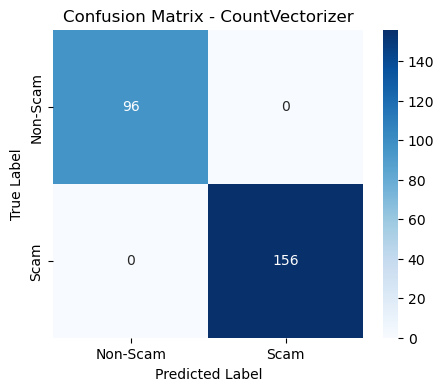

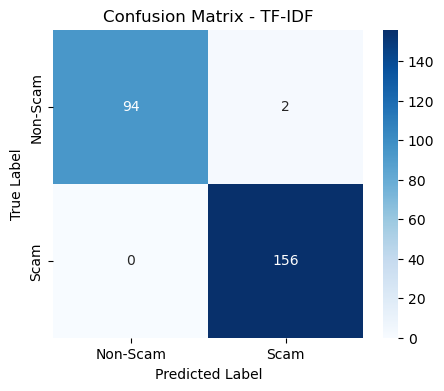

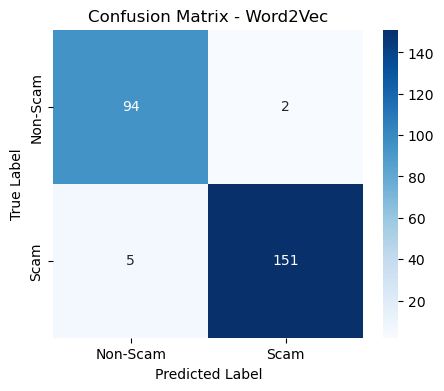

In [205]:
# Train Logistic Regression model
model_count = LogisticRegression(max_iter=1000)
model_count.fit(X_train_count, y_train_count)
model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
model_w2v = LogisticRegression(max_iter=1000)
model_w2v.fit(X_train_w2v, y_train_w2v)

# Evaluate models
y_pred_count = model_count.predict(X_test_count)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
y_pred_w2v = model_w2v.predict(X_test_w2v)

# Function to evaluate models and return performance metrics
def evaluate_model(model_name, y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return [model_name, acc, precision, recall, f1]

# Evaluate each model and store results
results = []
results.append(evaluate_model("CountVectorizer", y_test_count, y_pred_count))
results.append(evaluate_model("TF-IDF", y_test_tfidf, y_pred_tfidf))
results.append(evaluate_model("Word2Vec", y_test_w2v, y_pred_w2v))

# Create a DataFrame for a clean table output
df_results = pd.DataFrame(results, columns=["Method", "Accuracy", "Precision", "Recall", "F1-Score"])

# Display the results as a Pandas DataFrame table
print(df_results)

# Plot confusion matrices
def plot_confusion_matrix(model_name, y_test, y_pred):
    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Scam", "Scam"], yticklabels=["Non-Scam", "Scam"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix("CountVectorizer", y_test_count, y_pred_count)
plot_confusion_matrix("TF-IDF", y_test_tfidf, y_pred_tfidf)
plot_confusion_matrix("Word2Vec", y_test_w2v, y_pred_w2v)


# Split, Train (BERT)

In [206]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, df["labels"], test_size=0.2, random_state=42)

# Train Logistic Regression model for BERT
model_bert = LogisticRegression(max_iter=1000)
model_bert.fit(X_train_bert, y_train_bert)

# Evaluate BERT model
y_pred_bert = model_bert.predict(X_test_bert)
results.append(evaluate_model("BERT", y_test_bert, y_pred_bert))

In [207]:
X_train_sbert, X_test_sbert, y_train_sbert, y_test_sbert = train_test_split(X_sbert, df["labels"], test_size=0.2, random_state=42)

# Train Logistic Regression model for Sentence BERT
model_sbert = LogisticRegression(max_iter=1000)
model_sbert.fit(X_train_sbert, y_train_sbert)

# Evaluate Sentence BERT model
y_pred_sbert = model_sbert.predict(X_test_sbert)
results.append(evaluate_model("Sentence BERT", y_test_sbert, y_pred_sbert))

            Method  Accuracy  Precision    Recall  F1-Score
0  CountVectorizer  1.000000   1.000000  1.000000  1.000000
1           TF-IDF  0.992063   0.987342  1.000000  0.993631
2         Word2Vec  0.972222   0.986928  0.967949  0.977346
3             BERT  0.980159   0.987097  0.980769  0.983923
4    Sentence BERT  0.968254   0.968354  0.980769  0.974522


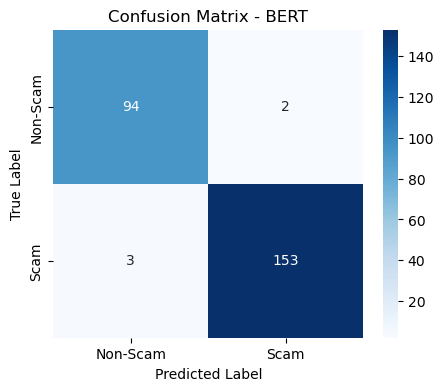

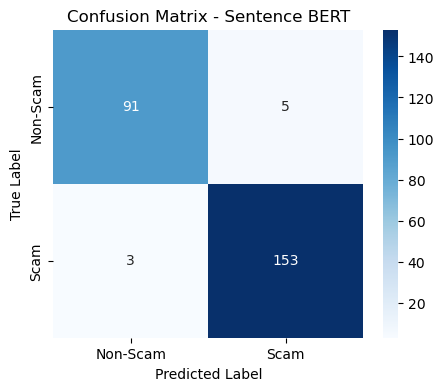

In [208]:
# Create a DataFrame for a clean table output
df_results = pd.DataFrame(results, columns=["Method", "Accuracy", "Precision", "Recall", "F1-Score"])

# Display the results as a Pandas DataFrame table
print(df_results)

# Plot confusion matrix for BERT
plot_confusion_matrix("BERT", y_test_bert, y_pred_bert)

# Plot confusion matrix for Sentence BERT
plot_confusion_matrix("Sentence BERT", y_test_sbert, y_pred_sbert)

# Test (Count/TFIDF/Word2Vec)

In [214]:
# Use the count vectorizer model to predict the label and probability of a new dialogue
new_dialogue = """
Hey it is your friend Alex from uni!
Hi Alex, how are you? What are you calling for?
Just wanted to check in and see how you're doing
I'm doing fine, thanks for asking
I heard you got a new job, congratulations!
Yeah, cool. Let's catch up soon
"""
new_dialogue = clean_text(new_dialogue)  # Apply your text preprocessing

# Convert text into a sparse matrix using CountVectorizer
X_new = count_vectorizer.transform([new_dialogue])

# Get the predicted label
y_new = model_count.predict(X_new)

# Get probability estimates
prob_new = model_count.predict_proba(X_new)

# Ensure correct interpretation of prediction
label_index = np.argmax(prob_new)  # Find index of max probability
label = "Scam" if label_index == 1 else "Not Scam"

print("Predicted label:", label)
print("Predicted label probability:", prob_new[0][label_index])

Predicted label: Scam
Predicted label probability: 0.889314706164071


In [215]:
# Use the TFIDF Logistic Regression model to predict the label and the probability of the label for the following dialogue
dialogue = """
Hey it is your friend Alex from uni!
Hi Alex, how are you? What are you calling for?
Just wanted to check in and see how you're doing
I'm doing fine, thanks for asking
I heard you got a new job, congratulations!
Yeah, cool. Let's catch up soon
"""
cleaned_dialogue = clean_text(dialogue)
X = tfidf_vectorizer.transform([cleaned_dialogue])
y_pred = model_tfidf.predict(X)
y_pred_proba = model_tfidf.predict_proba(X)
label_index = np.argmax(y_pred_proba)  # Get index of highest probability
label = "Scam" if label_index == 1 else "Not Scam"
print("Predicted label:", label)
print("Predicted label probability:", y_pred_proba[0][label_index])


Predicted label: Not Scam
Predicted label probability: 0.7084217870329614


In [216]:
# Use the Word2Vec Logistic Regression model to predict the label and the probability of the label for the following dialogue
dialogue = """
Hey it is your friend Alex from uni!
Hi Alex, how are you? What are you calling for?
Just wanted to check in and see how you're doing
I'm doing fine, thanks for asking
I heard you got a new job, congratulations!
Yeah, cool. Let's catch up soon
"""

cleaned_dialogue = clean_text(dialogue)
sentence = cleaned_dialogue.split()
vectors = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
if vectors:
    X = np.mean(vectors, axis=0)
    X = X.reshape(1, -1)
    y_pred = model_w2v.predict(X)
    y_pred_proba = model_w2v.predict_proba(X)
    label_index = np.argmax(y_pred_proba)  # Get index of highest probability
    label = "Scam" if label_index == 1 else "Not Scam"
    print("Predicted label:", label)
    print("Predicted label probability:", y_pred_proba[0][label_index])
else:
    print("No word vectors found for the dialogue")


Predicted label: Not Scam
Predicted label probability: 0.8199195231627854


# Test (BERT / SBERT)

In [224]:
# Function to predict using the trained BERT + Logistic Regression model
def predict_with_bert(text, model_bert, tokenizer, bert_model, device):
    # Clean the text (using your existing clean_text function)
    cleaned_text = clean_text(text)
    
    # Tokenize and encode the text
    encoded = tokenizer.encode_plus(
        cleaned_text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    
    # Get BERT embeddings
    bert_model.eval()
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    
    # Use logistic regression model for prediction
    y_pred = model_bert.predict(embeddings)
    y_pred_proba = model_bert.predict_proba(embeddings)
    
    label_index = np.argmax(y_pred_proba)
    label = "Scam" if label_index == 1 else "Not Scam"  # Adjust labels based on your classes
    
    return {
        'prediction': label,
        'probability': y_pred_proba[0][label_index],
        'all_probabilities': y_pred_proba[0]
    }

# Example usage
dialogue = """
Hey it is your friend Alex from uni!
Hi Alex, how are you? What are you calling for?
Just wanted to check in and see how you're doing
I'm doing fine, thanks for asking
I heard you got a new job, congratulations!
Yeah, cool. Let's catch up soon
"""

# Make prediction
prediction_result = predict_with_bert(
    dialogue, 
    model_bert,  # Your trained logistic regression model
    tokenizer,   # Your BERT tokenizer
    model,       # Your BERT model
    device       # Your device (cuda/cpu)
)

# Print results
print(f"Predicted label: {prediction_result['prediction']}")
print(f"Predicted label probability: {prediction_result['probability']:.4f}")

# If you want to see all class probabilities
class_names = ["Not Scam", "Scam"]  # Adjust based on your actual class names
for i, prob in enumerate(prediction_result['all_probabilities']):
    print(f"Probability of {class_names[i]}: {prob:.4f}")

Predicted label: Scam
Predicted label probability: 0.9183
Probability of Not Scam: 0.0817
Probability of Scam: 0.9183


In [225]:
# Function to predict using the trained Sentence BERT + Logistic Regression model
def predict_with_sbert(text, model_sbert):
    # Clean the text (using your existing clean_text function)
    cleaned_text = clean_text(text)
    
    # Encode the text using Sentence BERT
    embedding = sbert_model.encode(cleaned_text)
    
    # Use logistic regression model for prediction
    y_pred = model_sbert.predict([embedding])
    y_pred_proba = model_sbert.predict_proba([embedding])
    
    label_index = np.argmax(y_pred_proba)
    label = "Scam" if label_index == 1 else "Not Scam"  # Adjust labels based on your classes
    
    return {
        'prediction': label,
        'probability': y_pred_proba[0][label_index],
        'all_probabilities': y_pred_proba[0]
    }

# Example usage
dialogue = """
Hey it is your friend Alex from uni!
Hi Alex, how are you? What are you calling for?
Just wanted to check in and see how you're doing
I'm doing fine, thanks for asking
I heard you got a new job, congratulations!
Yeah, cool. Let's catch up soon
"""

# Make prediction
prediction_result = predict_with_sbert(dialogue, model_sbert)

# Print results
print(f"Predicted label: {prediction_result['prediction']}")
print(f"Predicted label probability: {prediction_result['probability']:.4f}")

Predicted label: Not Scam
Predicted label probability: 0.8044
